# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Epochs)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [1024]
batch_sizes = [256, 512, 1024, 2048]

# hidden_units default = [100, 200, 400, 200]
hidden_units = [
    [100, 200, 400, 200]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2]
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp2_batch_size_256
model_params:  batch_size=256, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f39eb4dac20>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
983/983 [==============================] - 11s 7ms/step - loss: 0.8054 - accuracy: 0.5021 - auc: 0.5038 - val_loss: 0.6944 - val_accuracy: 0.5262 - val_auc: 0.5372
Epoch 2/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7319 - accuracy: 0.5132 - auc: 0.5182 - val_loss: 0.6900 - val_accuracy: 0.5319 - val_auc: 0.5474
Epoch 3/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7162 - accuracy: 0.5160 - auc: 0.5211 - val_loss: 0.6871 - val_accuracy: 0.5391 - val_auc: 0.5570
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7051 - accuracy: 0.5213 - auc: 0.5298 - val_loss: 0.6866 - val_accuracy: 0.5416 - val_auc: 0.5587
Epoch 5/50
983/983 [==============================] - 6s 6ms/step - lo

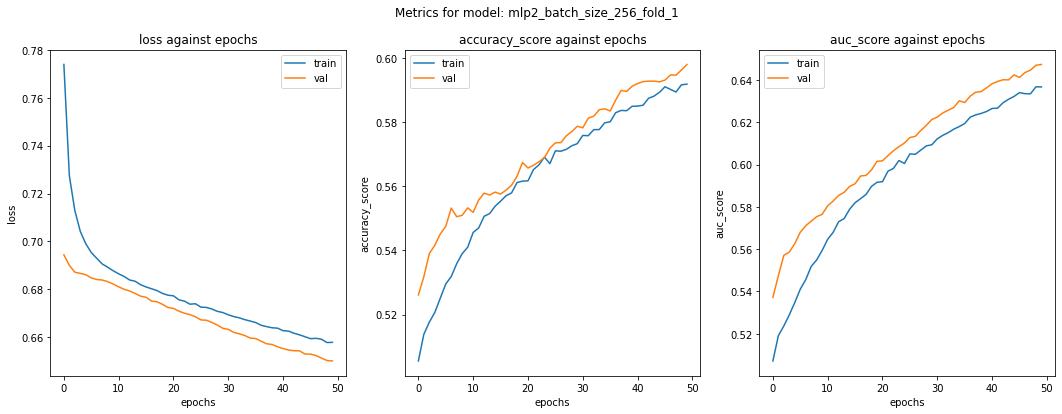

training model fold 2
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8281 - accuracy: 0.5034 - auc: 0.5052 - val_loss: 0.6930 - val_accuracy: 0.5314 - val_auc: 0.5459
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7394 - accuracy: 0.5112 - auc: 0.5153 - val_loss: 0.6889 - val_accuracy: 0.5419 - val_auc: 0.5580
Epoch 3/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7196 - accuracy: 0.5142 - auc: 0.5206 - val_loss: 0.6870 - val_accuracy: 0.5427 - val_auc: 0.5633
Epoch 4/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7100 - accuracy: 0.5153 - auc: 0.5213 - val_loss: 0.6855 - val_accuracy: 0.5471 - val_auc: 0.5686
Epoch 5/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7023 - accuracy: 0.5215 - auc: 0.5299 - val_loss: 0.6853 - val_accuracy: 0.5496 - val_auc: 0.5697
Epoch 6/50
983/983 [==============================] - 6s 6ms/step - loss: 0.6980 - accuracy: 0.5247 - auc: 0

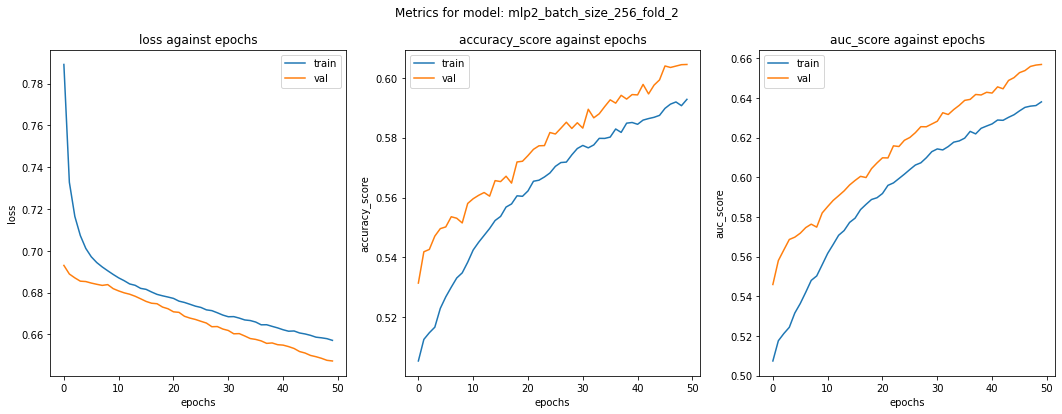

training model fold 3
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8076 - accuracy: 0.5050 - auc: 0.5071 - val_loss: 0.6981 - val_accuracy: 0.5194 - val_auc: 0.5301
Epoch 2/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7345 - accuracy: 0.5121 - auc: 0.5170 - val_loss: 0.6904 - val_accuracy: 0.5331 - val_auc: 0.5485
Epoch 3/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7160 - accuracy: 0.5164 - auc: 0.5232 - val_loss: 0.6889 - val_accuracy: 0.5372 - val_auc: 0.5541
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7069 - accuracy: 0.5200 - auc: 0.5277 - val_loss: 0.6869 - val_accuracy: 0.5399 - val_auc: 0.5619
Epoch 5/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7004 - accuracy: 0.5257 - auc: 0.5354 - val_loss: 0.6868 - val_accuracy: 0.5456 - val_auc: 0.5645
Epoch 6/50
983/983 [==============================] - 6s 7ms/step - loss: 0.6968 - accuracy: 0.5279 - auc: 0

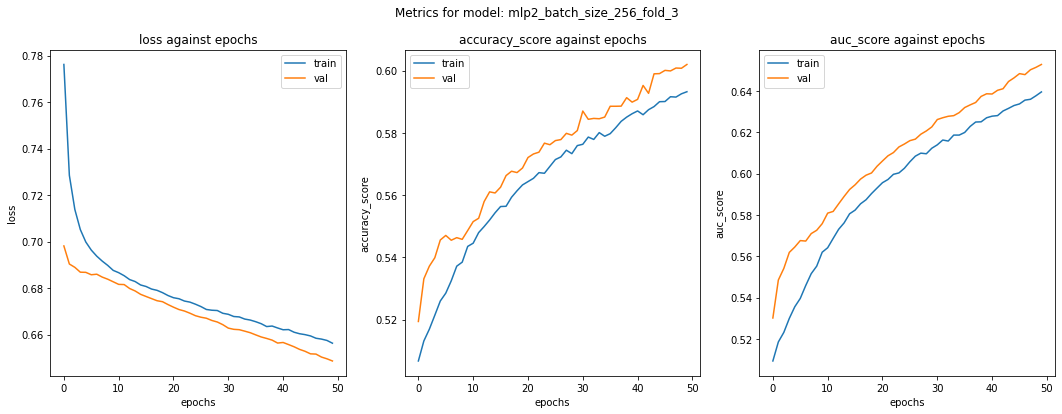

training model fold 4
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8071 - accuracy: 0.5050 - auc: 0.5073 - val_loss: 0.6970 - val_accuracy: 0.5298 - val_auc: 0.5383
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7352 - accuracy: 0.5086 - auc: 0.5131 - val_loss: 0.6901 - val_accuracy: 0.5340 - val_auc: 0.5480
Epoch 3/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7147 - accuracy: 0.5163 - auc: 0.5239 - val_loss: 0.6877 - val_accuracy: 0.5390 - val_auc: 0.5581
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7058 - accuracy: 0.5196 - auc: 0.5277 - val_loss: 0.6861 - val_accuracy: 0.5427 - val_auc: 0.5630
Epoch 5/50
983/983 [==============================] - 6s 6ms/step - loss: 0.6996 - accuracy: 0.5249 - auc: 0.5340 - val_loss: 0.6859 - val_accuracy: 0.5433 - val_auc: 0.5651
Epoch 6/50
983/983 [==============================] - 6s 7ms/step - loss: 0.6959 - accuracy: 0.5276 - auc: 0

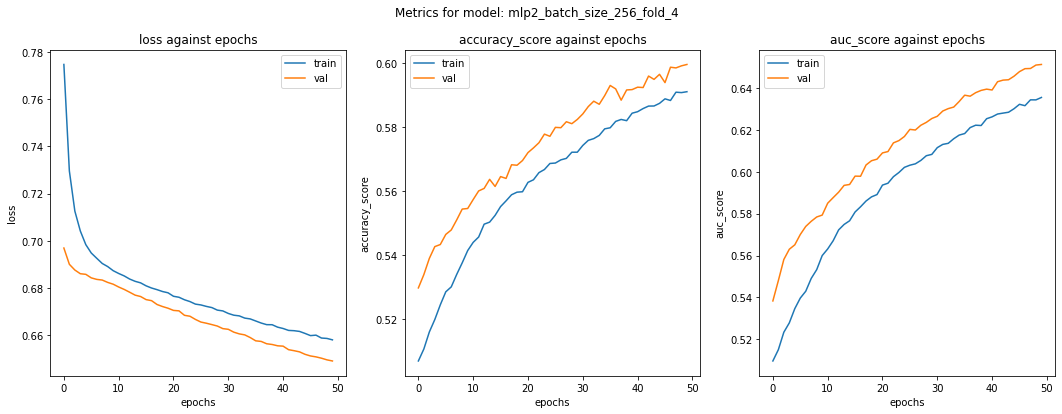

training model fold 5
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8163 - accuracy: 0.5034 - auc: 0.5047 - val_loss: 0.6957 - val_accuracy: 0.5308 - val_auc: 0.5408
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7338 - accuracy: 0.5157 - auc: 0.5213 - val_loss: 0.6909 - val_accuracy: 0.5328 - val_auc: 0.5481
Epoch 3/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7165 - accuracy: 0.5158 - auc: 0.5229 - val_loss: 0.6882 - val_accuracy: 0.5402 - val_auc: 0.5544
Epoch 4/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7077 - accuracy: 0.5169 - auc: 0.5246 - val_loss: 0.6871 - val_accuracy: 0.5394 - val_auc: 0.5591
Epoch 5/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7007 - accuracy: 0.5246 - auc: 0.5341 - val_loss: 0.6863 - val_accuracy: 0.5403 - val_auc: 0.5617
Epoch 6/50
983/983 [==============================] - 6s 6ms/step - loss: 0.6962 - accuracy: 0.5287 - auc: 0

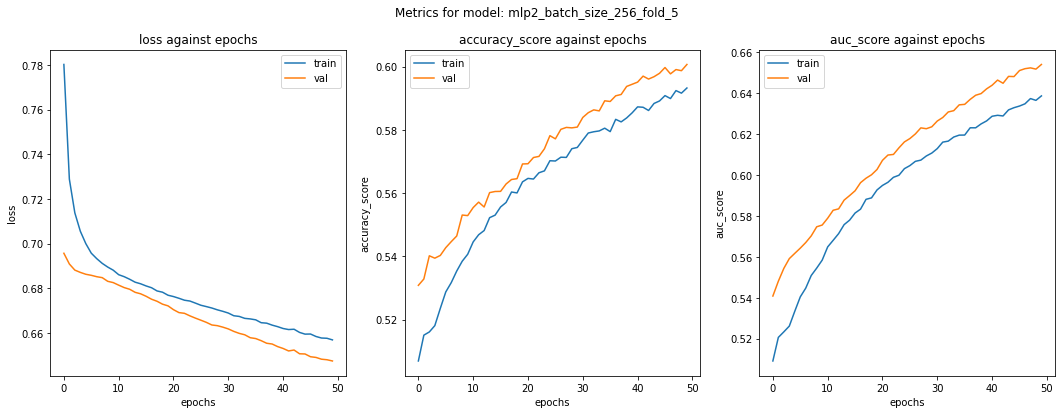

training model fold 6
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8037 - accuracy: 0.5058 - auc: 0.5082 - val_loss: 0.6949 - val_accuracy: 0.5263 - val_auc: 0.5369
Epoch 2/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7311 - accuracy: 0.5100 - auc: 0.5155 - val_loss: 0.6906 - val_accuracy: 0.5344 - val_auc: 0.5458
Epoch 3/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7153 - accuracy: 0.5132 - auc: 0.5189 - val_loss: 0.6883 - val_accuracy: 0.5365 - val_auc: 0.5523
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 0.7066 - accuracy: 0.5178 - auc: 0.5247 - val_loss: 0.6865 - val_accuracy: 0.5402 - val_auc: 0.5605
Epoch 5/50
983/983 [==============================] - 6s 7ms/step - loss: 0.7002 - accuracy: 0.5239 - auc: 0.5328 - val_loss: 0.6865 - val_accuracy: 0.5405 - val_auc: 0.5602
Epoch 6/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6954 - accuracy: 0.5285 - auc: 0

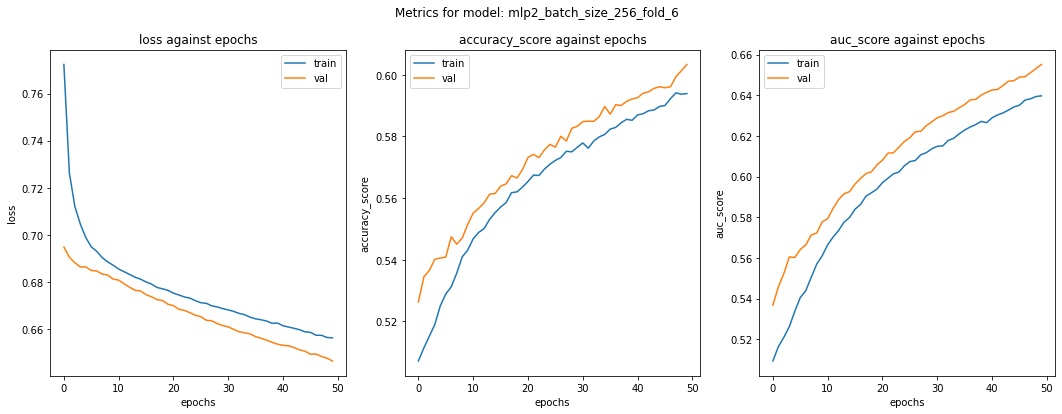

training model fold 7
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8219 - accuracy: 0.5046 - auc: 0.5067 - val_loss: 0.7000 - val_accuracy: 0.5128 - val_auc: 0.5256
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7383 - accuracy: 0.5123 - auc: 0.5158 - val_loss: 0.6923 - val_accuracy: 0.5260 - val_auc: 0.5444
Epoch 3/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7172 - accuracy: 0.5143 - auc: 0.5207 - val_loss: 0.6889 - val_accuracy: 0.5374 - val_auc: 0.5518
Epoch 4/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7062 - accuracy: 0.5202 - auc: 0.5275 - val_loss: 0.6874 - val_accuracy: 0.5369 - val_auc: 0.5552
Epoch 5/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7002 - accuracy: 0.5223 - auc: 0.5311 - val_loss: 0.6865 - val_accuracy: 0.5362 - val_auc: 0.5585
Epoch 6/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6953 - accuracy: 0.5281 - auc: 0

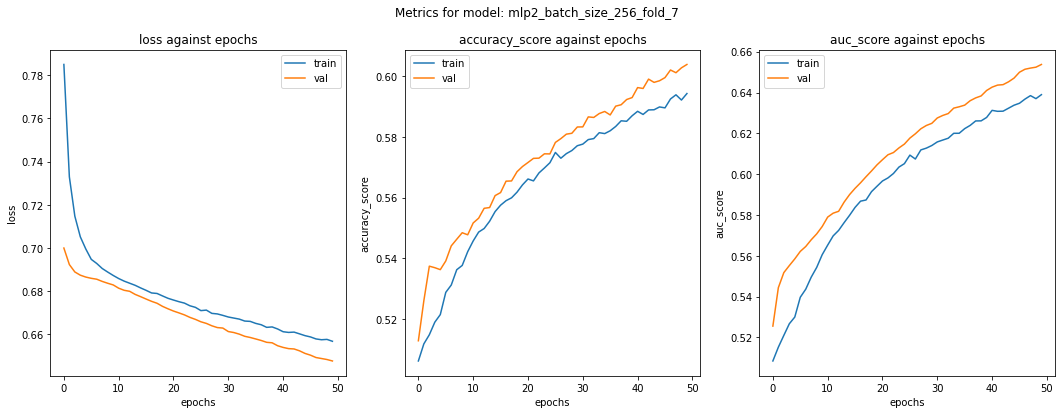

training model fold 8
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.8087 - accuracy: 0.5058 - auc: 0.5061 - val_loss: 0.6943 - val_accuracy: 0.5294 - val_auc: 0.5387
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7347 - accuracy: 0.5100 - auc: 0.5131 - val_loss: 0.6893 - val_accuracy: 0.5339 - val_auc: 0.5511
Epoch 3/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7144 - accuracy: 0.5174 - auc: 0.5247 - val_loss: 0.6869 - val_accuracy: 0.5409 - val_auc: 0.5586
Epoch 4/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7070 - accuracy: 0.5210 - auc: 0.5273 - val_loss: 0.6868 - val_accuracy: 0.5424 - val_auc: 0.5603
Epoch 5/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7018 - accuracy: 0.5219 - auc: 0.5314 - val_loss: 0.6858 - val_accuracy: 0.5426 - val_auc: 0.5630
Epoch 6/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6975 - accuracy: 0.5270 - auc: 0

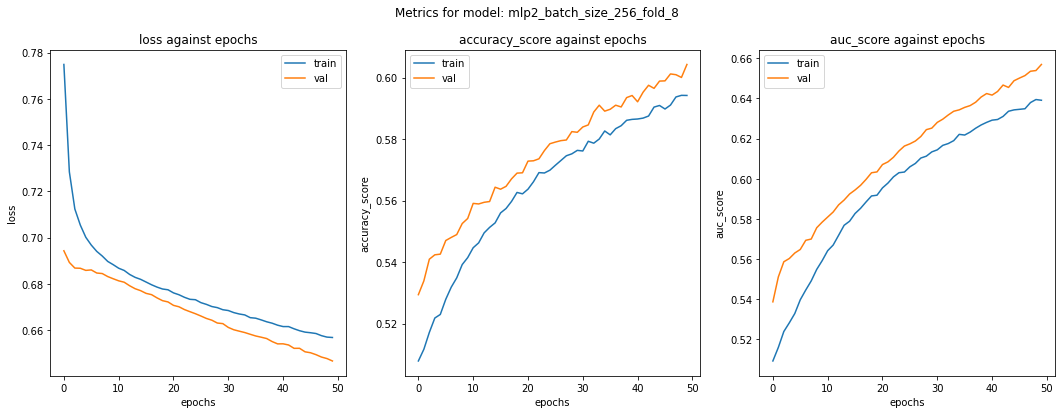

training model fold 9
Epoch 1/50
983/983 [==============================] - 9s 7ms/step - loss: 0.8069 - accuracy: 0.5047 - auc: 0.5071 - val_loss: 0.6975 - val_accuracy: 0.5237 - val_auc: 0.5330
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7339 - accuracy: 0.5110 - auc: 0.5152 - val_loss: 0.6909 - val_accuracy: 0.5321 - val_auc: 0.5457
Epoch 3/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7150 - accuracy: 0.5153 - auc: 0.5212 - val_loss: 0.6883 - val_accuracy: 0.5360 - val_auc: 0.5527
Epoch 4/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7046 - accuracy: 0.5198 - auc: 0.5279 - val_loss: 0.6871 - val_accuracy: 0.5405 - val_auc: 0.5572
Epoch 5/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6986 - accuracy: 0.5241 - auc: 0.5341 - val_loss: 0.6858 - val_accuracy: 0.5463 - val_auc: 0.5650
Epoch 6/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6948 - accuracy: 0.5294 - auc: 0

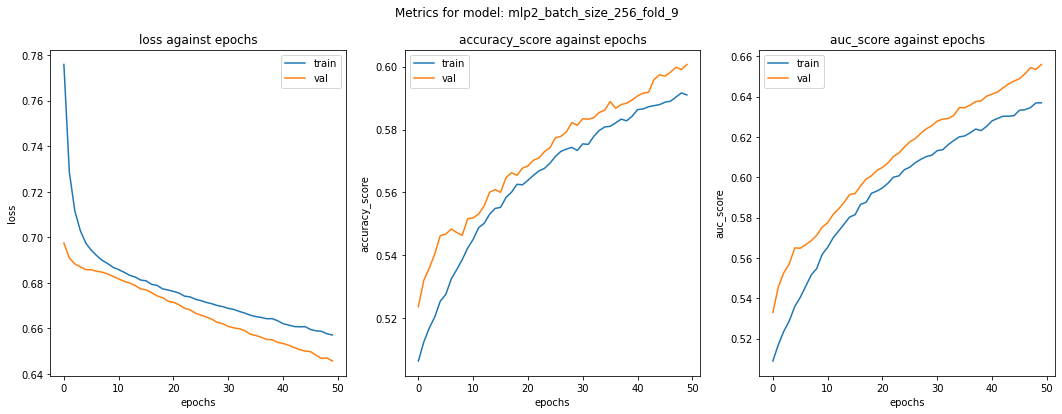

training model fold 10
Epoch 1/50
983/983 [==============================] - 8s 7ms/step - loss: 0.7975 - accuracy: 0.5065 - auc: 0.5091 - val_loss: 0.6938 - val_accuracy: 0.5300 - val_auc: 0.5430
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7306 - accuracy: 0.5136 - auc: 0.5179 - val_loss: 0.6891 - val_accuracy: 0.5375 - val_auc: 0.5547
Epoch 3/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7122 - accuracy: 0.5176 - auc: 0.5247 - val_loss: 0.6876 - val_accuracy: 0.5409 - val_auc: 0.5567
Epoch 4/50
983/983 [==============================] - 7s 7ms/step - loss: 0.7041 - accuracy: 0.5211 - auc: 0.5298 - val_loss: 0.6868 - val_accuracy: 0.5439 - val_auc: 0.5626
Epoch 5/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6993 - accuracy: 0.5242 - auc: 0.5340 - val_loss: 0.6848 - val_accuracy: 0.5467 - val_auc: 0.5679
Epoch 6/50
983/983 [==============================] - 7s 7ms/step - loss: 0.6944 - accuracy: 0.5309 - auc: 

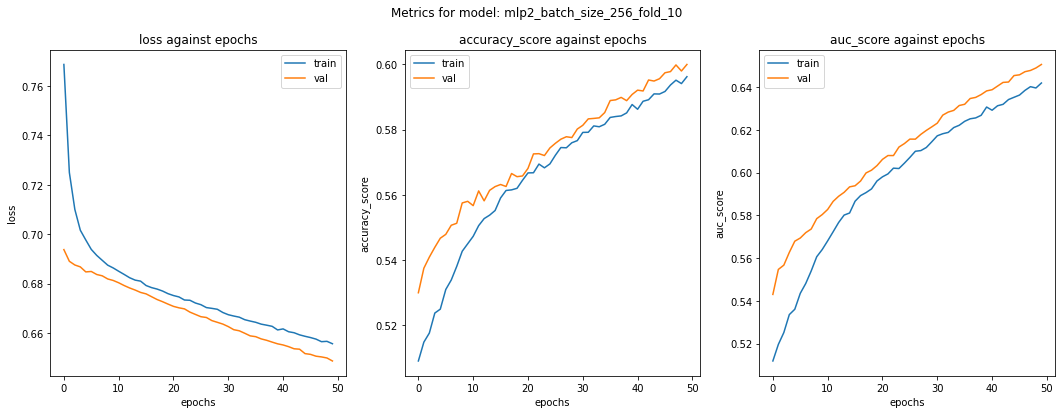

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1140.2293062160666, 0.6016697171468952, 0.6009790352842662, 9028.0, 7778.5, 5901.7, 5224.9]
saved model metrics

model_name:  mlp2_batch_size_512
model_params:  batch_size=512, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f39eb4dac20>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8315 - accuracy: 0.5062 - auc: 0.5078 - val_loss: 0.7002 - val_accuracy: 0.5236 - val_auc: 0.5378
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7566 - accuracy: 0.5077 - auc: 0.5128 - val_loss: 0.6937 - val_accuracy: 0.5320 - val_auc: 0.5440
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7323 - accuracy: 0.5140 - auc: 0.5193 - val_loss: 0.6902 - val_accuracy: 0.5348 - val_auc: 0.5544
Epoch 4/50
492/492 [======

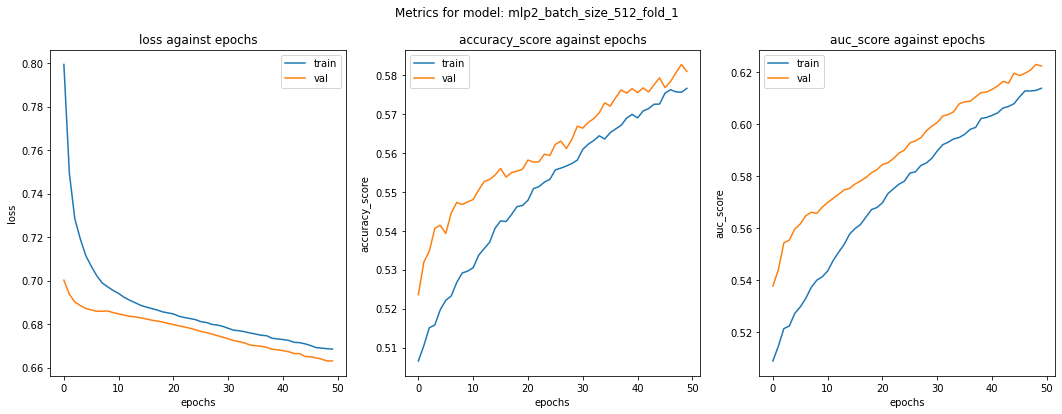

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8333 - accuracy: 0.5026 - auc: 0.5035 - val_loss: 0.7008 - val_accuracy: 0.5265 - val_auc: 0.5423
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7524 - accuracy: 0.5112 - auc: 0.5148 - val_loss: 0.6930 - val_accuracy: 0.5384 - val_auc: 0.5512
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7297 - accuracy: 0.5139 - auc: 0.5184 - val_loss: 0.6909 - val_accuracy: 0.5376 - val_auc: 0.5561
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7188 - accuracy: 0.5173 - auc: 0.5238 - val_loss: 0.6876 - val_accuracy: 0.5421 - val_auc: 0.5635
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7116 - accuracy: 0.5205 - auc: 0.5271 - val_loss: 0.6866 - val_accuracy: 0.5466 - val_auc: 0.5666
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7064 - accuracy: 0.5218 - auc: 0

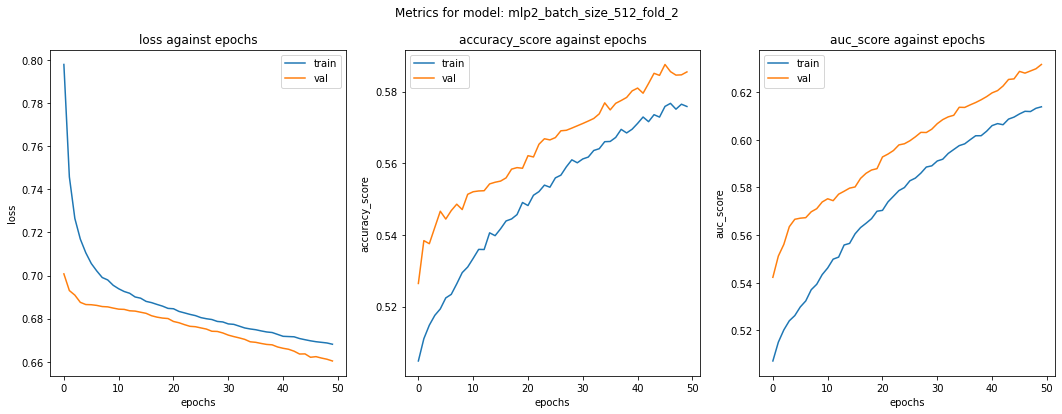

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8217 - accuracy: 0.5014 - auc: 0.5035 - val_loss: 0.6995 - val_accuracy: 0.5211 - val_auc: 0.5336
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7487 - accuracy: 0.5090 - auc: 0.5120 - val_loss: 0.6936 - val_accuracy: 0.5274 - val_auc: 0.5410
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7283 - accuracy: 0.5110 - auc: 0.5155 - val_loss: 0.6908 - val_accuracy: 0.5297 - val_auc: 0.5464
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7160 - accuracy: 0.5174 - auc: 0.5236 - val_loss: 0.6890 - val_accuracy: 0.5346 - val_auc: 0.5519
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7105 - accuracy: 0.5171 - auc: 0.5254 - val_loss: 0.6889 - val_accuracy: 0.5343 - val_auc: 0.5527
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7064 - accuracy: 0.5179 - auc: 0

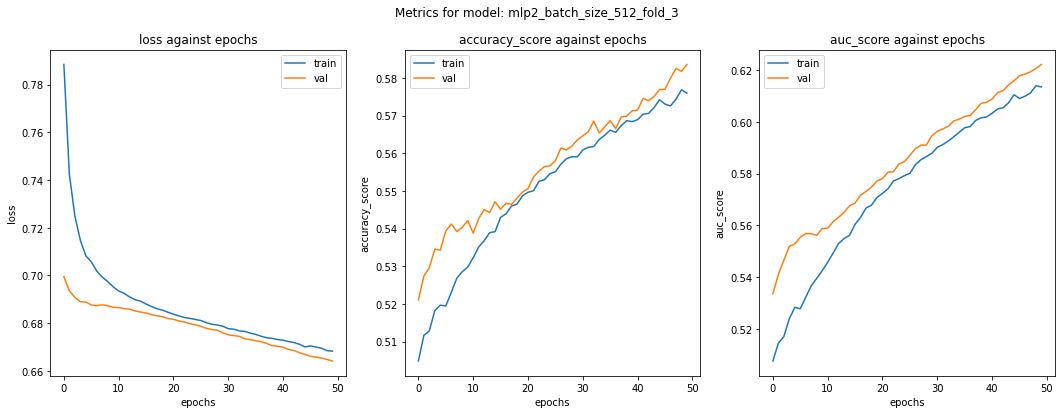

training model fold 4
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8220 - accuracy: 0.5045 - auc: 0.5074 - val_loss: 0.6977 - val_accuracy: 0.5278 - val_auc: 0.5389
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7462 - accuracy: 0.5109 - auc: 0.5153 - val_loss: 0.6901 - val_accuracy: 0.5351 - val_auc: 0.5525
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7272 - accuracy: 0.5136 - auc: 0.5179 - val_loss: 0.6889 - val_accuracy: 0.5391 - val_auc: 0.5570
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7156 - accuracy: 0.5172 - auc: 0.5232 - val_loss: 0.6864 - val_accuracy: 0.5426 - val_auc: 0.5631
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7108 - accuracy: 0.5177 - auc: 0.5255 - val_loss: 0.6868 - val_accuracy: 0.5428 - val_auc: 0.5625
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7062 - accuracy: 0.5198 - auc: 0

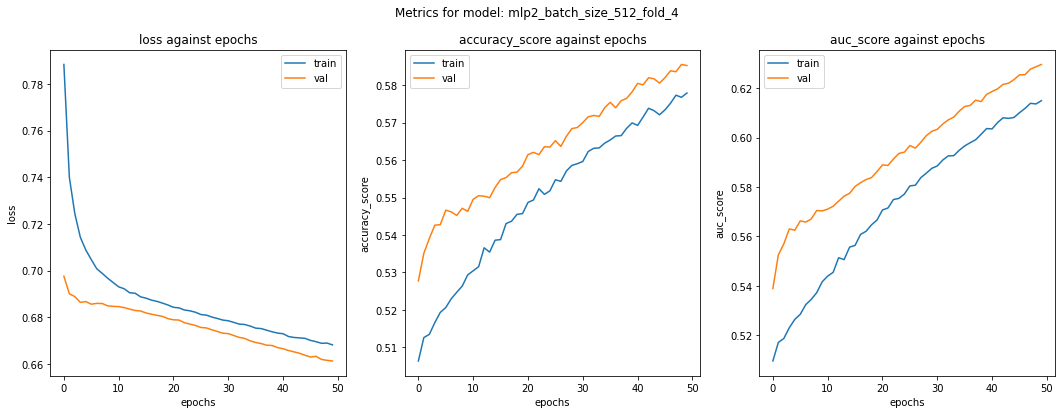

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8140 - accuracy: 0.5055 - auc: 0.5076 - val_loss: 0.6998 - val_accuracy: 0.5233 - val_auc: 0.5374
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7462 - accuracy: 0.5104 - auc: 0.5137 - val_loss: 0.6925 - val_accuracy: 0.5321 - val_auc: 0.5461
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7279 - accuracy: 0.5112 - auc: 0.5160 - val_loss: 0.6908 - val_accuracy: 0.5309 - val_auc: 0.5517
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7160 - accuracy: 0.5176 - auc: 0.5228 - val_loss: 0.6893 - val_accuracy: 0.5364 - val_auc: 0.5554
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7090 - accuracy: 0.5176 - auc: 0.5262 - val_loss: 0.6879 - val_accuracy: 0.5394 - val_auc: 0.5573
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7045 - accuracy: 0.5192 - auc: 0

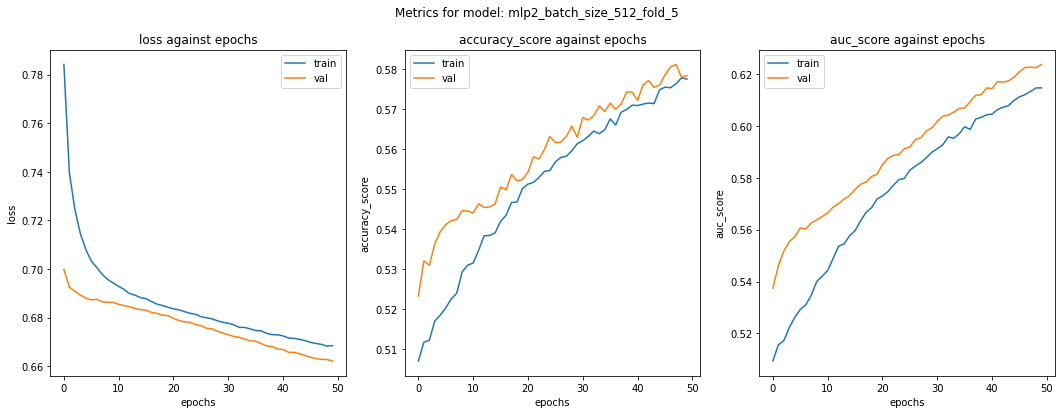

training model fold 6
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8095 - accuracy: 0.5070 - auc: 0.5092 - val_loss: 0.6969 - val_accuracy: 0.5249 - val_auc: 0.5322
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7447 - accuracy: 0.5097 - auc: 0.5142 - val_loss: 0.6917 - val_accuracy: 0.5318 - val_auc: 0.5448
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7259 - accuracy: 0.5144 - auc: 0.5206 - val_loss: 0.6905 - val_accuracy: 0.5351 - val_auc: 0.5488
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7172 - accuracy: 0.5156 - auc: 0.5219 - val_loss: 0.6880 - val_accuracy: 0.5391 - val_auc: 0.5548
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7099 - accuracy: 0.5178 - auc: 0.5260 - val_loss: 0.6874 - val_accuracy: 0.5374 - val_auc: 0.5547
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7050 - accuracy: 0.5216 - auc: 0

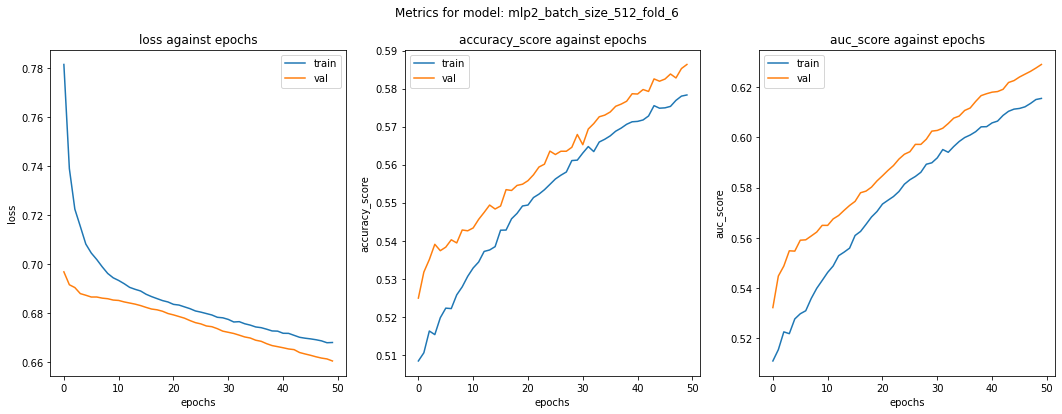

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8218 - accuracy: 0.5040 - auc: 0.5062 - val_loss: 0.6991 - val_accuracy: 0.5208 - val_auc: 0.5327
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7479 - accuracy: 0.5097 - auc: 0.5148 - val_loss: 0.6935 - val_accuracy: 0.5243 - val_auc: 0.5407
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7294 - accuracy: 0.5140 - auc: 0.5187 - val_loss: 0.6900 - val_accuracy: 0.5306 - val_auc: 0.5448
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7183 - accuracy: 0.5119 - auc: 0.5185 - val_loss: 0.6891 - val_accuracy: 0.5332 - val_auc: 0.5493
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7104 - accuracy: 0.5215 - auc: 0.5274 - val_loss: 0.6877 - val_accuracy: 0.5375 - val_auc: 0.5538
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7052 - accuracy: 0.5214 - auc: 0

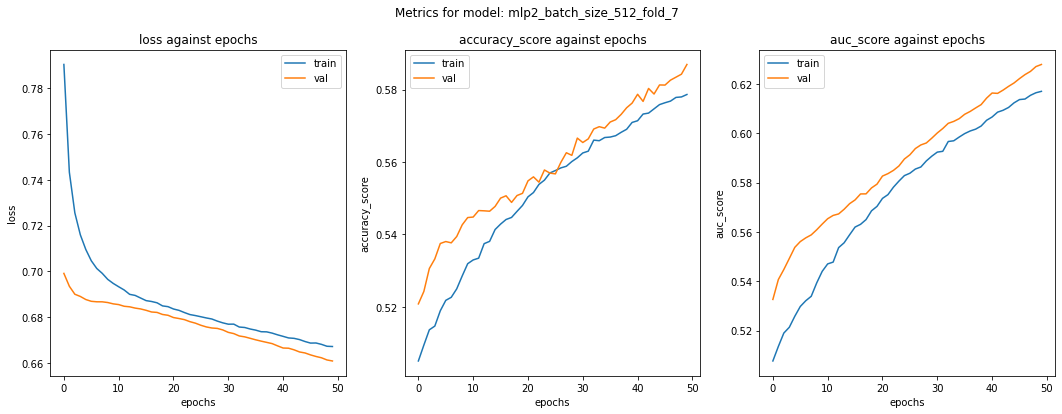

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8298 - accuracy: 0.5061 - auc: 0.5082 - val_loss: 0.6990 - val_accuracy: 0.5237 - val_auc: 0.5356
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7491 - accuracy: 0.5116 - auc: 0.5155 - val_loss: 0.6908 - val_accuracy: 0.5355 - val_auc: 0.5481
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7306 - accuracy: 0.5121 - auc: 0.5176 - val_loss: 0.6886 - val_accuracy: 0.5347 - val_auc: 0.5540
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7179 - accuracy: 0.5192 - auc: 0.5262 - val_loss: 0.6877 - val_accuracy: 0.5407 - val_auc: 0.5589
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7110 - accuracy: 0.5195 - auc: 0.5276 - val_loss: 0.6869 - val_accuracy: 0.5384 - val_auc: 0.5595
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7073 - accuracy: 0.5214 - auc: 0

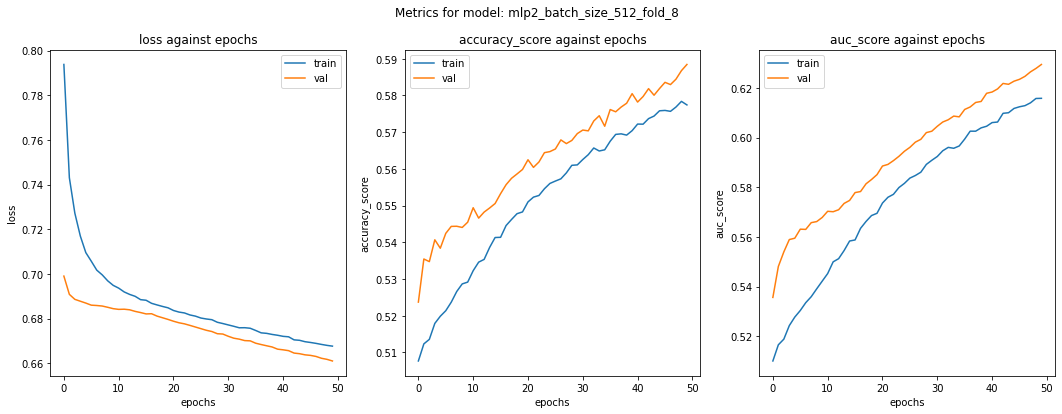

training model fold 9
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8196 - accuracy: 0.5037 - auc: 0.5047 - val_loss: 0.6973 - val_accuracy: 0.5272 - val_auc: 0.5363
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7445 - accuracy: 0.5114 - auc: 0.5159 - val_loss: 0.6936 - val_accuracy: 0.5309 - val_auc: 0.5440
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7275 - accuracy: 0.5149 - auc: 0.5192 - val_loss: 0.6910 - val_accuracy: 0.5326 - val_auc: 0.5477
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7162 - accuracy: 0.5170 - auc: 0.5241 - val_loss: 0.6892 - val_accuracy: 0.5382 - val_auc: 0.5528
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7097 - accuracy: 0.5204 - auc: 0.5265 - val_loss: 0.6882 - val_accuracy: 0.5352 - val_auc: 0.5558
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7041 - accuracy: 0.5217 - auc: 0

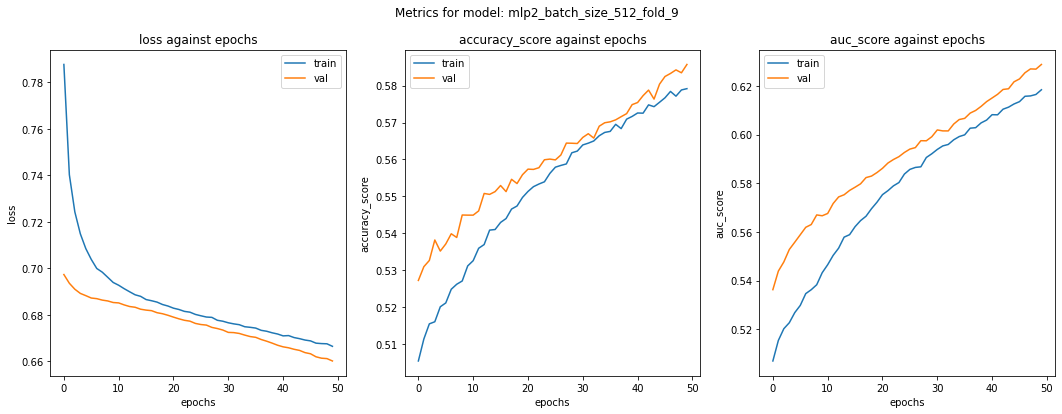

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8026 - accuracy: 0.5073 - auc: 0.5093 - val_loss: 0.6952 - val_accuracy: 0.5233 - val_auc: 0.5364
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7387 - accuracy: 0.5104 - auc: 0.5146 - val_loss: 0.6912 - val_accuracy: 0.5290 - val_auc: 0.5421
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7220 - accuracy: 0.5128 - auc: 0.5182 - val_loss: 0.6890 - val_accuracy: 0.5343 - val_auc: 0.5488
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7142 - accuracy: 0.5161 - auc: 0.5223 - val_loss: 0.6888 - val_accuracy: 0.5352 - val_auc: 0.5509
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7083 - accuracy: 0.5179 - auc: 0.5248 - val_loss: 0.6880 - val_accuracy: 0.5379 - val_auc: 0.5547
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7044 - accuracy: 0.5209 - auc: 

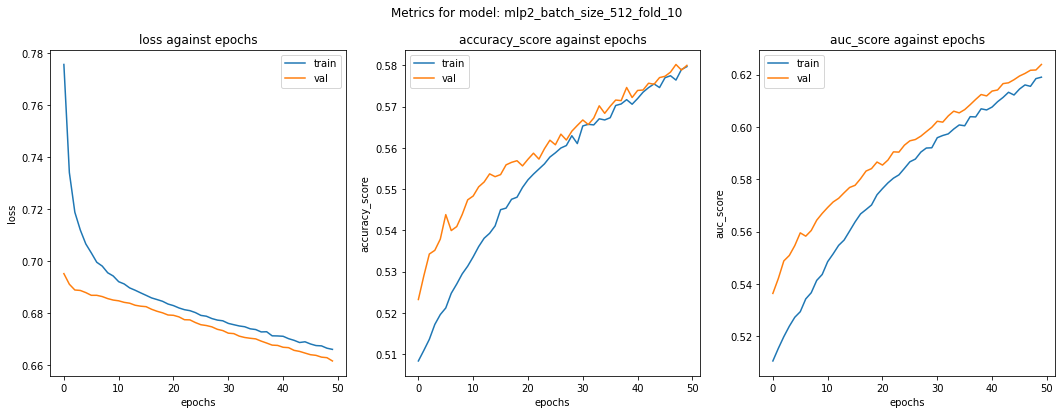

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [915.2234077798948, 0.5841063224831239, 0.583521897559723, 8717.2, 7598.7, 6081.5, 5535.7]
saved model metrics

model_name:  mlp2_batch_size_1024
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f39eb4dac20>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8194 - accuracy: 0.5048 - auc: 0.5061 - val_loss: 0.6952 - val_accuracy: 0.5167 - val_auc: 0.5259
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7506 - accuracy: 0.5066 - auc: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5270 - val_auc: 0.5395
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7312 - accuracy: 0.5120 - auc: 0.5178 - val_loss: 0.6898 - val_accuracy: 0.5319 - val_auc: 0.5474
Epoch 4/50
246/246 [=====

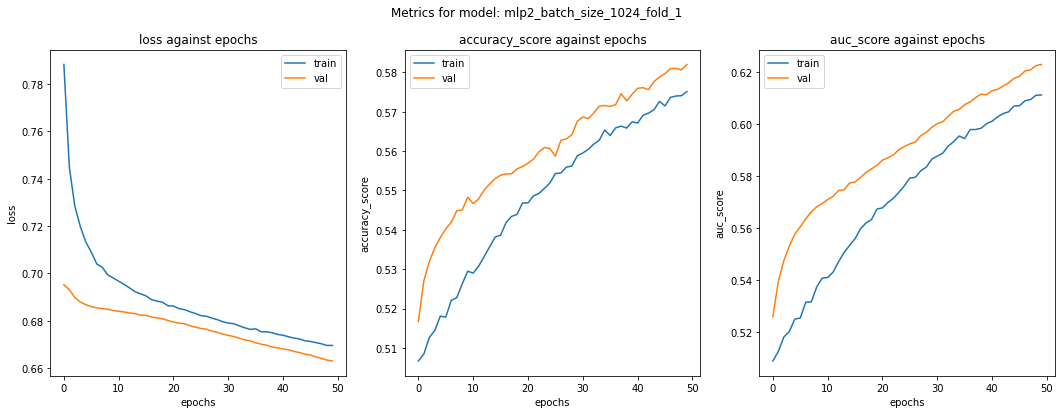

training model fold 2
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8212 - accuracy: 0.5027 - auc: 0.5040 - val_loss: 0.6973 - val_accuracy: 0.5192 - val_auc: 0.5262
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7521 - accuracy: 0.5109 - auc: 0.5143 - val_loss: 0.6956 - val_accuracy: 0.5271 - val_auc: 0.5383
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7351 - accuracy: 0.5132 - auc: 0.5178 - val_loss: 0.6926 - val_accuracy: 0.5337 - val_auc: 0.5464
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7229 - accuracy: 0.5164 - auc: 0.5221 - val_loss: 0.6899 - val_accuracy: 0.5385 - val_auc: 0.5519
Epoch 5/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7162 - accuracy: 0.5165 - auc: 0.5236 - val_loss: 0.6883 - val_accuracy: 0.5379 - val_auc: 0.5561
Epoch 6/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7106 - accuracy: 0.5202 - auc: 

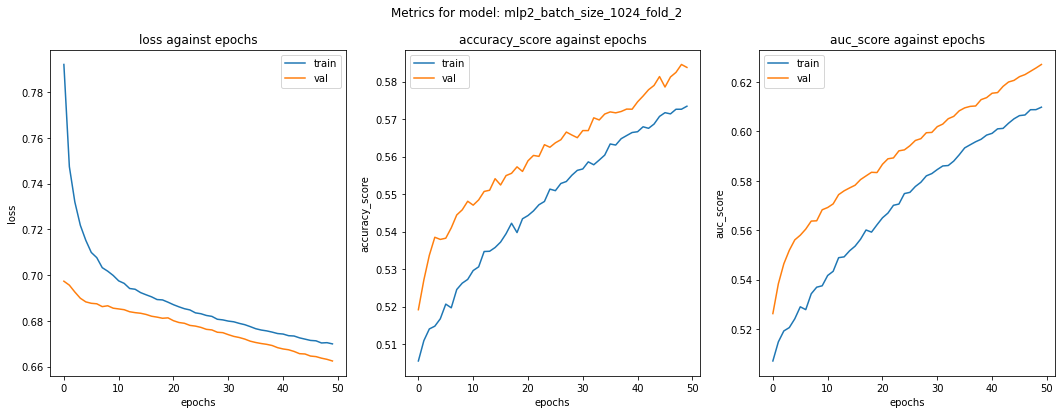

training model fold 3
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8344 - accuracy: 0.5049 - auc: 0.5056 - val_loss: 0.6961 - val_accuracy: 0.5238 - val_auc: 0.5350
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7601 - accuracy: 0.5096 - auc: 0.5142 - val_loss: 0.6944 - val_accuracy: 0.5292 - val_auc: 0.5431
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7405 - accuracy: 0.5112 - auc: 0.5168 - val_loss: 0.6910 - val_accuracy: 0.5336 - val_auc: 0.5504
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7290 - accuracy: 0.5150 - auc: 0.5208 - val_loss: 0.6890 - val_accuracy: 0.5368 - val_auc: 0.5550
Epoch 5/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7197 - accuracy: 0.5148 - auc: 0.5228 - val_loss: 0.6888 - val_accuracy: 0.5389 - val_auc: 0.5566
Epoch 6/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7139 - accuracy: 0.5194 - auc: 

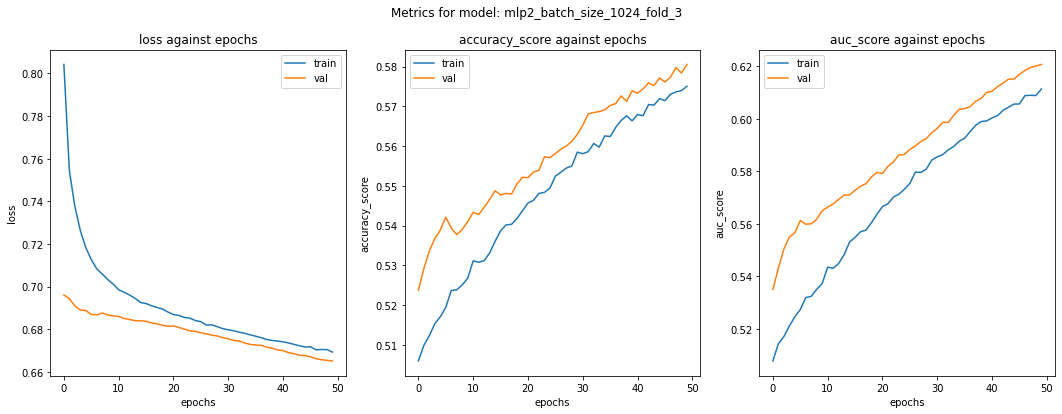

training model fold 4
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8233 - accuracy: 0.5036 - auc: 0.5046 - val_loss: 0.6947 - val_accuracy: 0.5166 - val_auc: 0.5306
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7527 - accuracy: 0.5102 - auc: 0.5143 - val_loss: 0.6931 - val_accuracy: 0.5287 - val_auc: 0.5418
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7356 - accuracy: 0.5131 - auc: 0.5183 - val_loss: 0.6893 - val_accuracy: 0.5332 - val_auc: 0.5504
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7243 - accuracy: 0.5158 - auc: 0.5213 - val_loss: 0.6877 - val_accuracy: 0.5378 - val_auc: 0.5561
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7174 - accuracy: 0.5173 - auc: 0.5246 - val_loss: 0.6872 - val_accuracy: 0.5406 - val_auc: 0.5584
Epoch 6/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7130 - accuracy: 0.5181 - auc: 

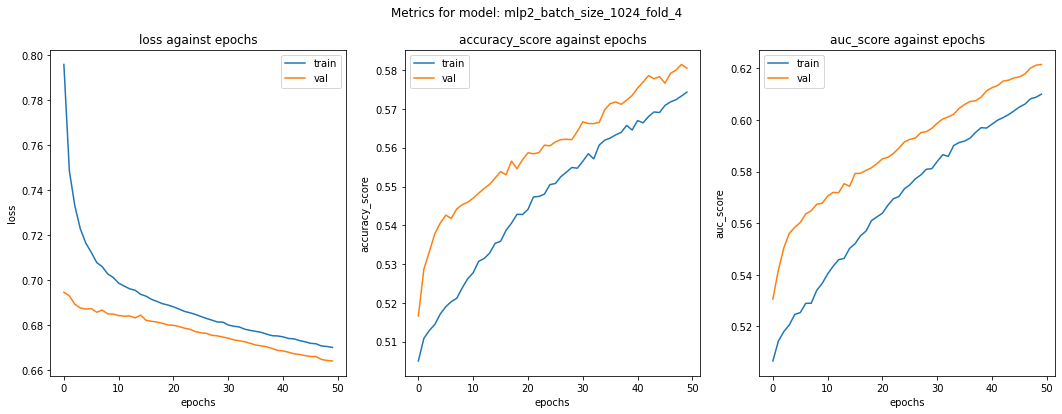

training model fold 5
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8325 - accuracy: 0.5017 - auc: 0.5031 - val_loss: 0.7010 - val_accuracy: 0.5120 - val_auc: 0.5287
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7605 - accuracy: 0.5071 - auc: 0.5104 - val_loss: 0.6955 - val_accuracy: 0.5248 - val_auc: 0.5359
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7391 - accuracy: 0.5110 - auc: 0.5147 - val_loss: 0.6927 - val_accuracy: 0.5288 - val_auc: 0.5439
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7264 - accuracy: 0.5163 - auc: 0.5219 - val_loss: 0.6897 - val_accuracy: 0.5332 - val_auc: 0.5509
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7194 - accuracy: 0.5158 - auc: 0.5224 - val_loss: 0.6881 - val_accuracy: 0.5383 - val_auc: 0.5557
Epoch 6/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7134 - accuracy: 0.5199 - auc: 

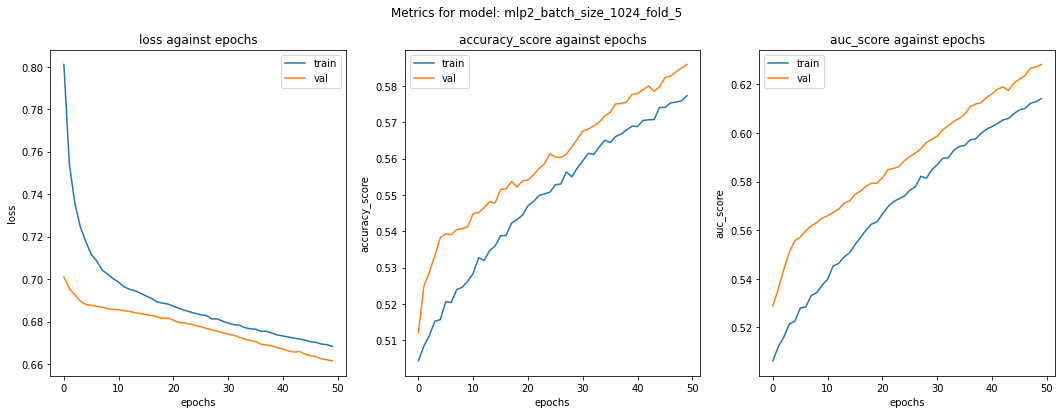

training model fold 6
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8201 - accuracy: 0.5050 - auc: 0.5066 - val_loss: 0.6972 - val_accuracy: 0.5147 - val_auc: 0.5258
Epoch 2/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7522 - accuracy: 0.5098 - auc: 0.5134 - val_loss: 0.6944 - val_accuracy: 0.5277 - val_auc: 0.5415
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7343 - accuracy: 0.5121 - auc: 0.5175 - val_loss: 0.6915 - val_accuracy: 0.5300 - val_auc: 0.5449
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7232 - accuracy: 0.5158 - auc: 0.5218 - val_loss: 0.6895 - val_accuracy: 0.5340 - val_auc: 0.5486
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7160 - accuracy: 0.5160 - auc: 0.5248 - val_loss: 0.6884 - val_accuracy: 0.5363 - val_auc: 0.5526
Epoch 6/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7118 - accuracy: 0.5183 - auc: 

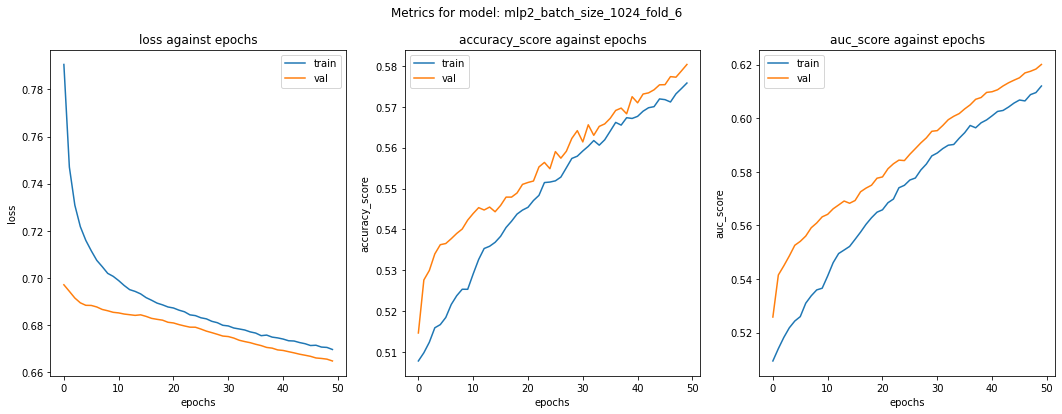

training model fold 7
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8242 - accuracy: 0.5037 - auc: 0.5038 - val_loss: 0.7006 - val_accuracy: 0.5165 - val_auc: 0.5255
Epoch 2/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7555 - accuracy: 0.5089 - auc: 0.5115 - val_loss: 0.6966 - val_accuracy: 0.5274 - val_auc: 0.5382
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7348 - accuracy: 0.5136 - auc: 0.5185 - val_loss: 0.6920 - val_accuracy: 0.5315 - val_auc: 0.5463
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7235 - accuracy: 0.5141 - auc: 0.5206 - val_loss: 0.6900 - val_accuracy: 0.5345 - val_auc: 0.5496
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7173 - accuracy: 0.5194 - auc: 0.5243 - val_loss: 0.6880 - val_accuracy: 0.5350 - val_auc: 0.5548
Epoch 6/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7123 - accuracy: 0.5187 - auc: 

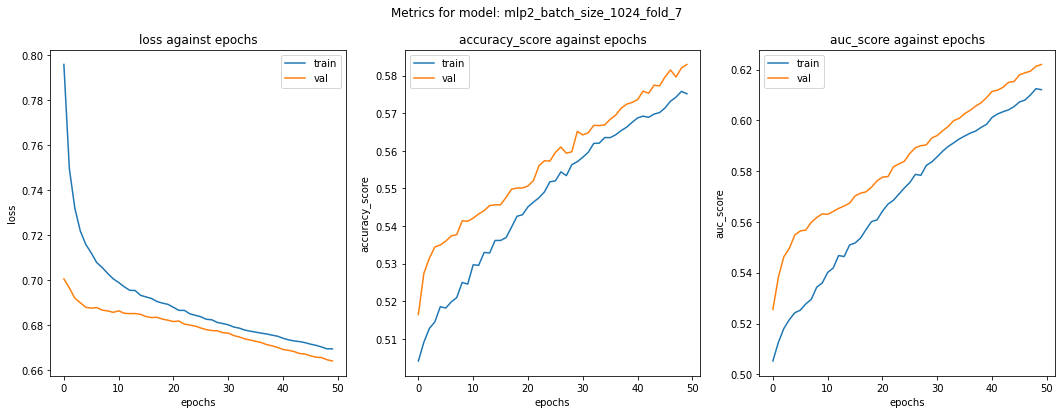

training model fold 8
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8344 - accuracy: 0.5038 - auc: 0.5044 - val_loss: 0.6975 - val_accuracy: 0.5158 - val_auc: 0.5265
Epoch 2/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7612 - accuracy: 0.5124 - auc: 0.5146 - val_loss: 0.6956 - val_accuracy: 0.5258 - val_auc: 0.5381
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7411 - accuracy: 0.5127 - auc: 0.5172 - val_loss: 0.6909 - val_accuracy: 0.5328 - val_auc: 0.5472
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7281 - accuracy: 0.5156 - auc: 0.5221 - val_loss: 0.6896 - val_accuracy: 0.5356 - val_auc: 0.5520
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7201 - accuracy: 0.5178 - auc: 0.5241 - val_loss: 0.6885 - val_accuracy: 0.5365 - val_auc: 0.5558
Epoch 6/50
246/246 [==============================] - 2s 10ms/step - loss: 0.7145 - accuracy: 0.5173 - auc:

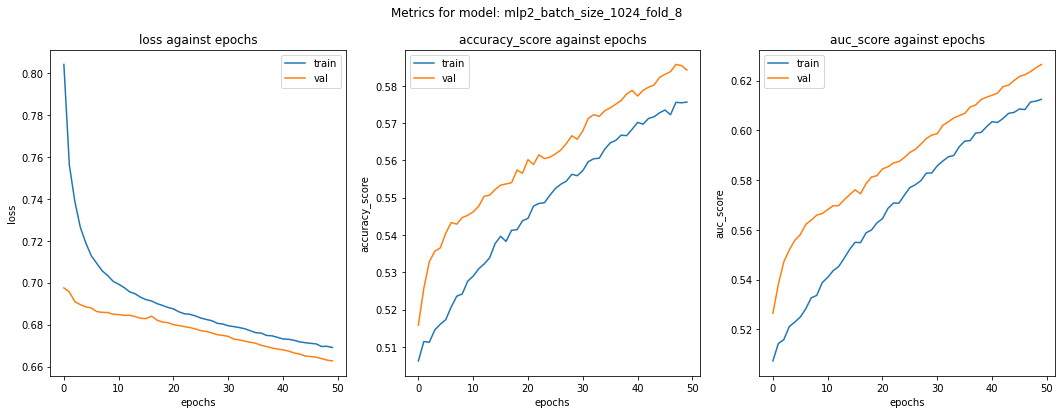

training model fold 9
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8374 - accuracy: 0.5015 - auc: 0.5036 - val_loss: 0.6981 - val_accuracy: 0.5108 - val_auc: 0.5231
Epoch 2/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7628 - accuracy: 0.5089 - auc: 0.5108 - val_loss: 0.6953 - val_accuracy: 0.5231 - val_auc: 0.5363
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7402 - accuracy: 0.5117 - auc: 0.5163 - val_loss: 0.6923 - val_accuracy: 0.5284 - val_auc: 0.5438
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7264 - accuracy: 0.5149 - auc: 0.5204 - val_loss: 0.6896 - val_accuracy: 0.5345 - val_auc: 0.5513
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7187 - accuracy: 0.5176 - auc: 0.5245 - val_loss: 0.6880 - val_accuracy: 0.5375 - val_auc: 0.5556
Epoch 6/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7135 - accuracy: 0.5187 - auc: 

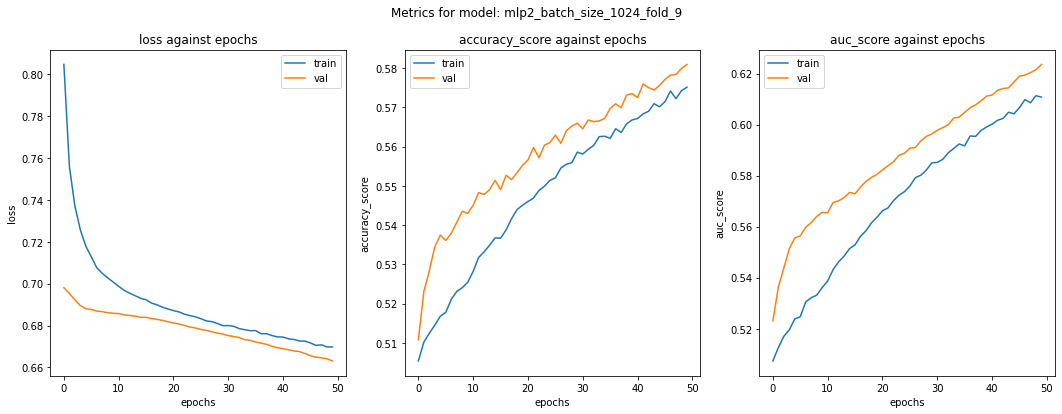

training model fold 10
Epoch 1/50
246/246 [==============================] - 4s 10ms/step - loss: 0.8308 - accuracy: 0.5044 - auc: 0.5057 - val_loss: 0.6981 - val_accuracy: 0.5274 - val_auc: 0.5339
Epoch 2/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7579 - accuracy: 0.5082 - auc: 0.5117 - val_loss: 0.6940 - val_accuracy: 0.5361 - val_auc: 0.5450
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7358 - accuracy: 0.5135 - auc: 0.5180 - val_loss: 0.6906 - val_accuracy: 0.5383 - val_auc: 0.5502
Epoch 4/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7268 - accuracy: 0.5125 - auc: 0.5180 - val_loss: 0.6902 - val_accuracy: 0.5381 - val_auc: 0.5530
Epoch 5/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7183 - accuracy: 0.5176 - auc: 0.5248 - val_loss: 0.6885 - val_accuracy: 0.5428 - val_auc: 0.5568
Epoch 6/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7130 - accuracy: 0.5193 - auc:

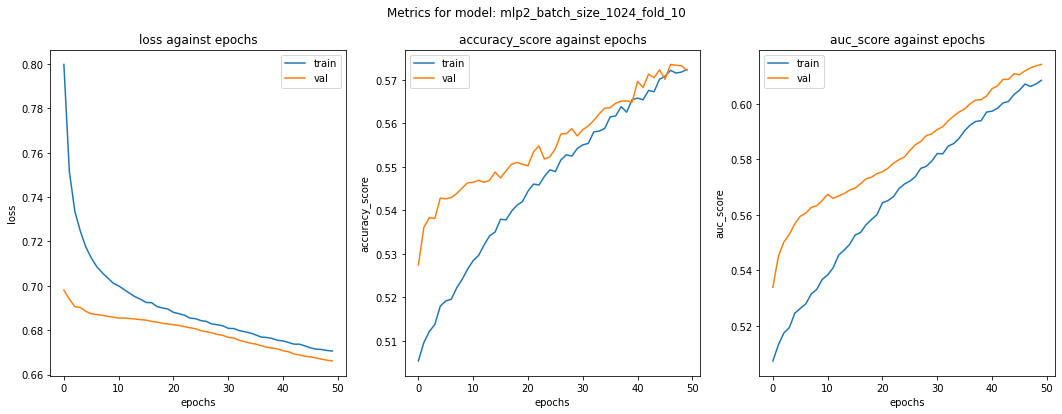

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [874.7365614344259, 0.5813425625076108, 0.580861576081084, 8632.3, 7606.4, 6073.8, 5620.6]
saved model metrics

model_name:  mlp2_batch_size_2048
model_params:  batch_size=2048, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7f39eb4dac20>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
123/123 [==============================] - 3s 13ms/step - loss: 0.8370 - accuracy: 0.5041 - auc: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.5121 - val_auc: 0.5204
Epoch 2/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7713 - accuracy: 0.5057 - auc: 0.5078 - val_loss: 0.6939 - val_accuracy: 0.5190 - val_auc: 0.5331
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7500 - accuracy: 0.5101 - auc: 0.5138 - val_loss: 0.6931 - val_accuracy: 0.5247 - val_auc: 0.5374
Epoch 4/50
123/123 [===

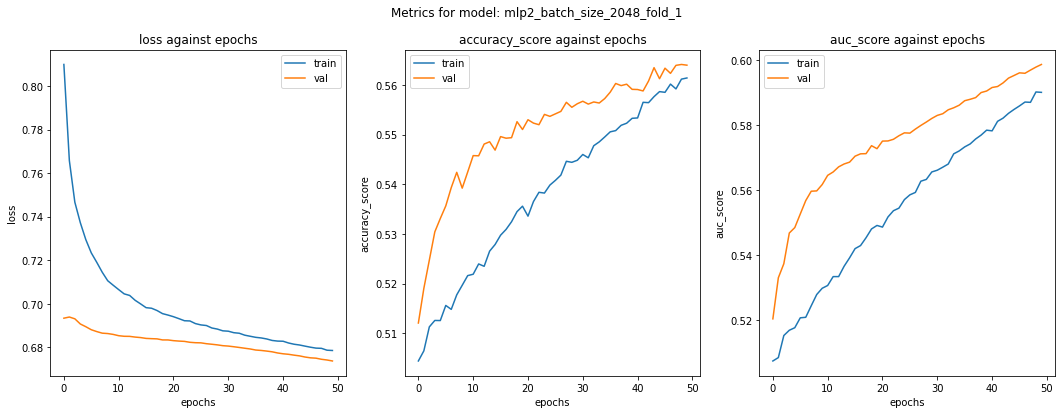

training model fold 2
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8221 - accuracy: 0.5043 - auc: 0.5052 - val_loss: 0.6942 - val_accuracy: 0.5187 - val_auc: 0.5261
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7648 - accuracy: 0.5053 - auc: 0.5069 - val_loss: 0.6940 - val_accuracy: 0.5269 - val_auc: 0.5379
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7437 - accuracy: 0.5105 - auc: 0.5149 - val_loss: 0.6928 - val_accuracy: 0.5339 - val_auc: 0.5458
Epoch 4/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7330 - accuracy: 0.5124 - auc: 0.5187 - val_loss: 0.6908 - val_accuracy: 0.5341 - val_auc: 0.5492
Epoch 5/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7259 - accuracy: 0.5140 - auc: 0.5198 - val_loss: 0.6893 - val_accuracy: 0.5375 - val_auc: 0.5544
Epoch 6/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7182 - accuracy: 0.5186 - 

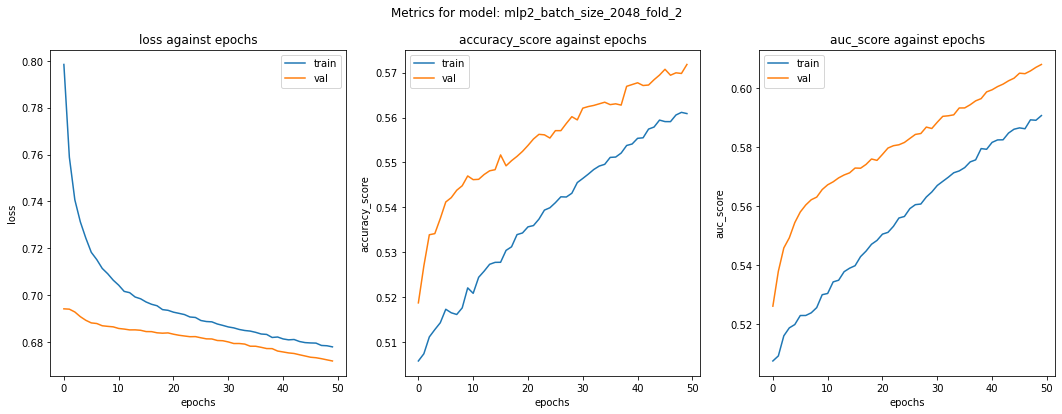

training model fold 3
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8428 - accuracy: 0.5033 - auc: 0.5055 - val_loss: 0.7014 - val_accuracy: 0.5059 - val_auc: 0.5212
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7772 - accuracy: 0.5072 - auc: 0.5103 - val_loss: 0.7000 - val_accuracy: 0.5184 - val_auc: 0.5344
Epoch 3/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7545 - accuracy: 0.5114 - auc: 0.5149 - val_loss: 0.6951 - val_accuracy: 0.5255 - val_auc: 0.5416
Epoch 4/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7411 - accuracy: 0.5135 - auc: 0.5187 - val_loss: 0.6946 - val_accuracy: 0.5280 - val_auc: 0.5448
Epoch 5/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7329 - accuracy: 0.5145 - auc: 0.5195 - val_loss: 0.6913 - val_accuracy: 0.5311 - val_auc: 0.5483
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7252 - accuracy: 0.5155 - 

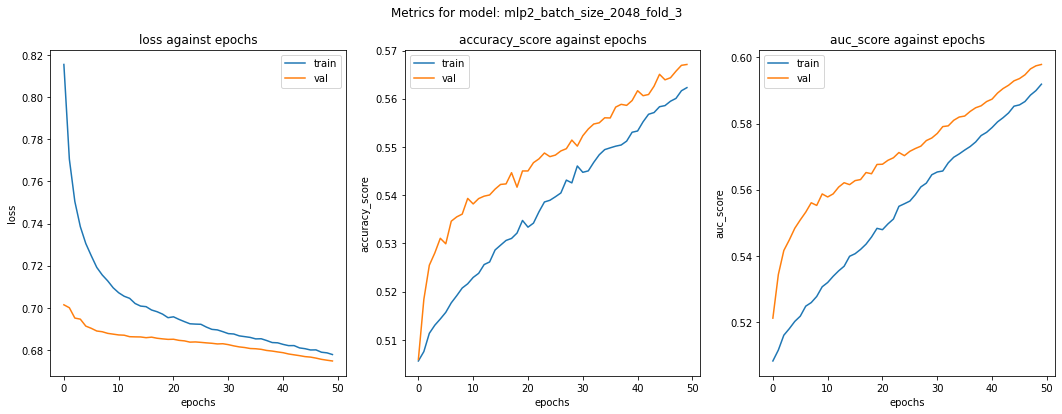

training model fold 4
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8445 - accuracy: 0.5040 - auc: 0.5072 - val_loss: 0.6946 - val_accuracy: 0.5163 - val_auc: 0.5206
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7745 - accuracy: 0.5066 - auc: 0.5102 - val_loss: 0.6949 - val_accuracy: 0.5185 - val_auc: 0.5305
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7544 - accuracy: 0.5094 - auc: 0.5136 - val_loss: 0.6934 - val_accuracy: 0.5283 - val_auc: 0.5399
Epoch 4/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7432 - accuracy: 0.5117 - auc: 0.5158 - val_loss: 0.6910 - val_accuracy: 0.5345 - val_auc: 0.5475
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7325 - accuracy: 0.5136 - auc: 0.5192 - val_loss: 0.6894 - val_accuracy: 0.5376 - val_auc: 0.5523
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7267 - accuracy: 0.5146 - 

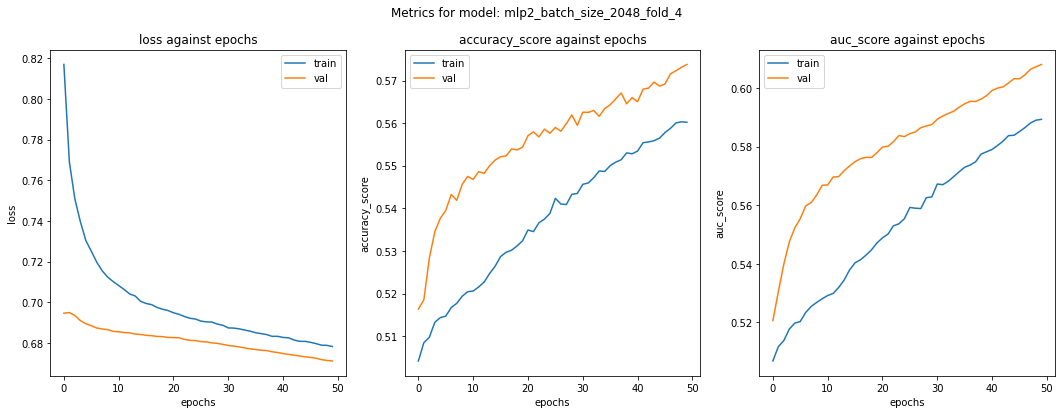

training model fold 5
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8405 - accuracy: 0.5060 - auc: 0.5066 - val_loss: 0.6942 - val_accuracy: 0.5153 - val_auc: 0.5234
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7753 - accuracy: 0.5083 - auc: 0.5092 - val_loss: 0.6940 - val_accuracy: 0.5240 - val_auc: 0.5346
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7503 - accuracy: 0.5121 - auc: 0.5147 - val_loss: 0.6939 - val_accuracy: 0.5292 - val_auc: 0.5402
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7398 - accuracy: 0.5132 - auc: 0.5170 - val_loss: 0.6912 - val_accuracy: 0.5299 - val_auc: 0.5472
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7299 - accuracy: 0.5163 - auc: 0.5220 - val_loss: 0.6900 - val_accuracy: 0.5317 - val_auc: 0.5496
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7258 - accuracy: 0.5120 - 

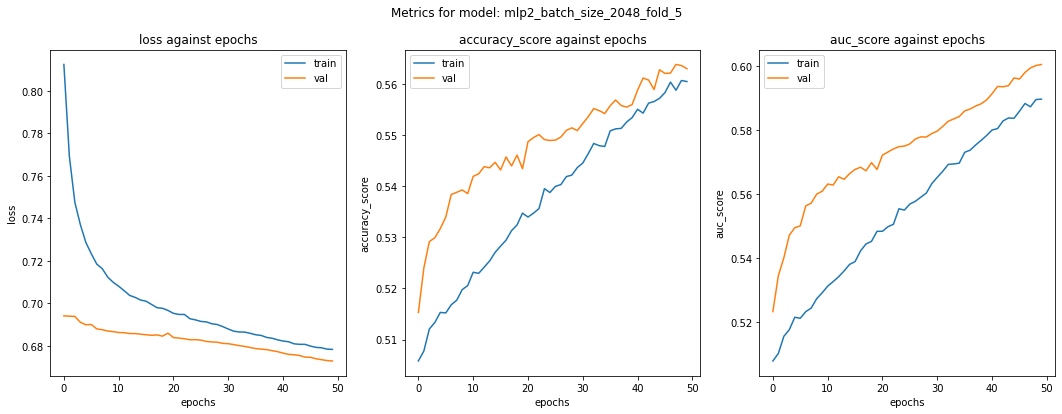

training model fold 6
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8778 - accuracy: 0.5057 - auc: 0.5063 - val_loss: 0.7013 - val_accuracy: 0.5171 - val_auc: 0.5211
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7838 - accuracy: 0.5088 - auc: 0.5128 - val_loss: 0.6991 - val_accuracy: 0.5260 - val_auc: 0.5330
Epoch 3/50
123/123 [==============================] - 1s 10ms/step - loss: 0.7611 - accuracy: 0.5104 - auc: 0.5148 - val_loss: 0.6977 - val_accuracy: 0.5306 - val_auc: 0.5392
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7488 - accuracy: 0.5128 - auc: 0.5172 - val_loss: 0.6936 - val_accuracy: 0.5367 - val_auc: 0.5464
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7373 - accuracy: 0.5124 - auc: 0.5173 - val_loss: 0.6918 - val_accuracy: 0.5346 - val_auc: 0.5482
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7311 - accuracy: 0.5141 - 

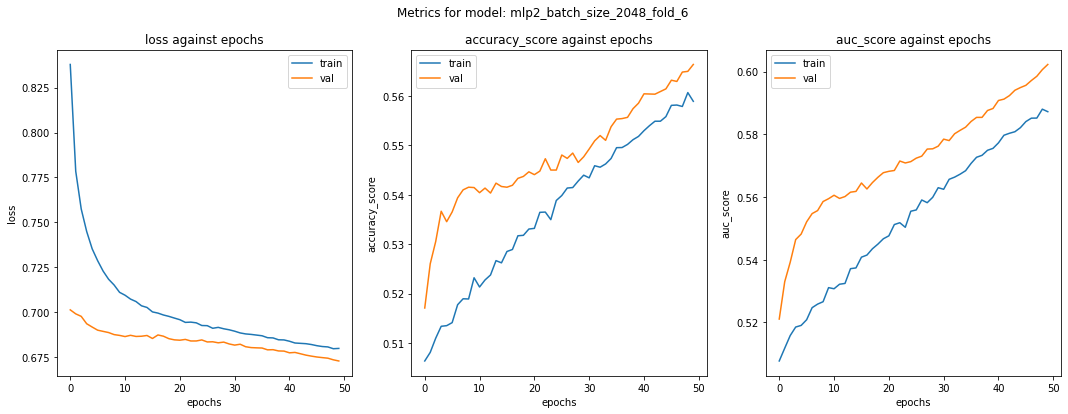

training model fold 7
Epoch 1/50
123/123 [==============================] - 3s 15ms/step - loss: 0.8592 - accuracy: 0.5016 - auc: 0.5025 - val_loss: 0.6988 - val_accuracy: 0.5075 - val_auc: 0.5270
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7771 - accuracy: 0.5089 - auc: 0.5115 - val_loss: 0.6985 - val_accuracy: 0.5207 - val_auc: 0.5385
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7559 - accuracy: 0.5121 - auc: 0.5165 - val_loss: 0.6937 - val_accuracy: 0.5285 - val_auc: 0.5437
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7411 - accuracy: 0.5152 - auc: 0.5192 - val_loss: 0.6923 - val_accuracy: 0.5301 - val_auc: 0.5473
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7329 - accuracy: 0.5173 - auc: 0.5220 - val_loss: 0.6905 - val_accuracy: 0.5309 - val_auc: 0.5501
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7256 - accuracy: 0.5194 - 

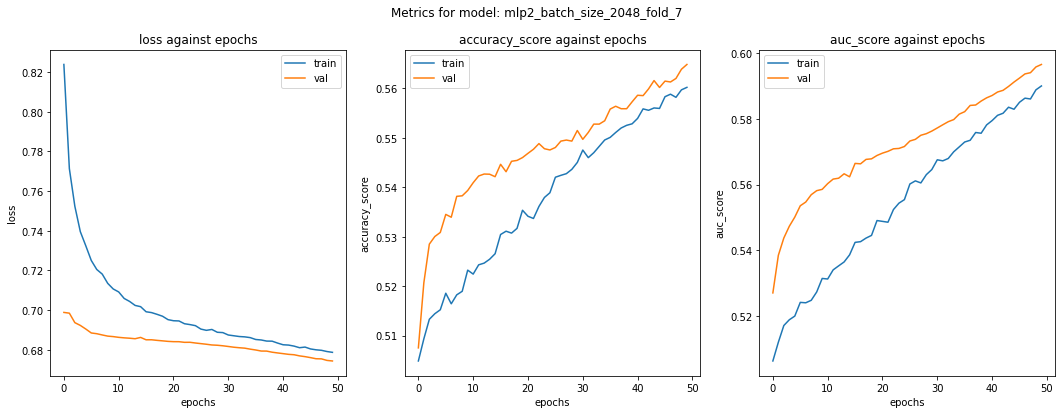

training model fold 8
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8325 - accuracy: 0.5044 - auc: 0.5048 - val_loss: 0.6933 - val_accuracy: 0.5181 - val_auc: 0.5294
Epoch 2/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7652 - accuracy: 0.5094 - auc: 0.5121 - val_loss: 0.6948 - val_accuracy: 0.5234 - val_auc: 0.5351
Epoch 3/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7444 - accuracy: 0.5134 - auc: 0.5180 - val_loss: 0.6939 - val_accuracy: 0.5269 - val_auc: 0.5390
Epoch 4/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7340 - accuracy: 0.5141 - auc: 0.5200 - val_loss: 0.6926 - val_accuracy: 0.5293 - val_auc: 0.5411
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7280 - accuracy: 0.5120 - auc: 0.5173 - val_loss: 0.6908 - val_accuracy: 0.5294 - val_auc: 0.5464
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7231 - accuracy: 0.5128 - 

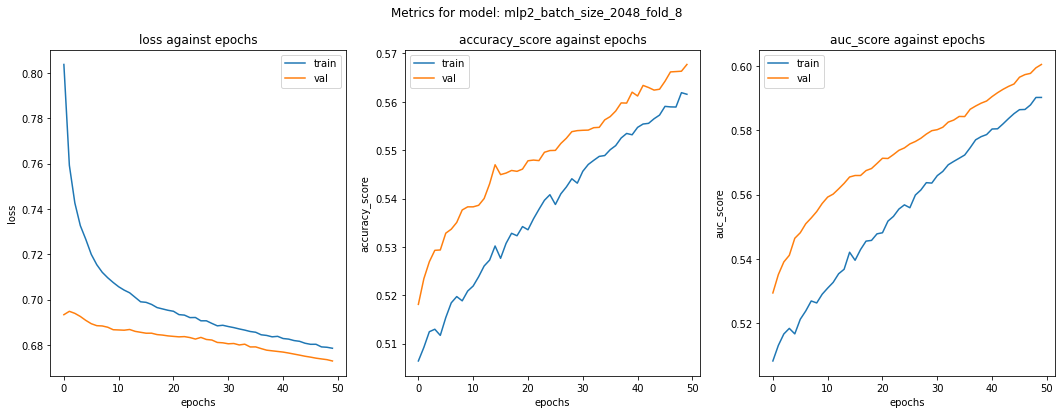

training model fold 9
Epoch 1/50
123/123 [==============================] - 3s 14ms/step - loss: 0.8228 - accuracy: 0.5058 - auc: 0.5086 - val_loss: 0.6937 - val_accuracy: 0.5155 - val_auc: 0.5229
Epoch 2/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7626 - accuracy: 0.5098 - auc: 0.5118 - val_loss: 0.6938 - val_accuracy: 0.5196 - val_auc: 0.5332
Epoch 3/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7427 - accuracy: 0.5120 - auc: 0.5165 - val_loss: 0.6928 - val_accuracy: 0.5279 - val_auc: 0.5409
Epoch 4/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7323 - accuracy: 0.5129 - auc: 0.5188 - val_loss: 0.6912 - val_accuracy: 0.5316 - val_auc: 0.5471
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.7247 - accuracy: 0.5167 - auc: 0.5232 - val_loss: 0.6907 - val_accuracy: 0.5322 - val_auc: 0.5484
Epoch 6/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7206 - accuracy: 0.5175 - 

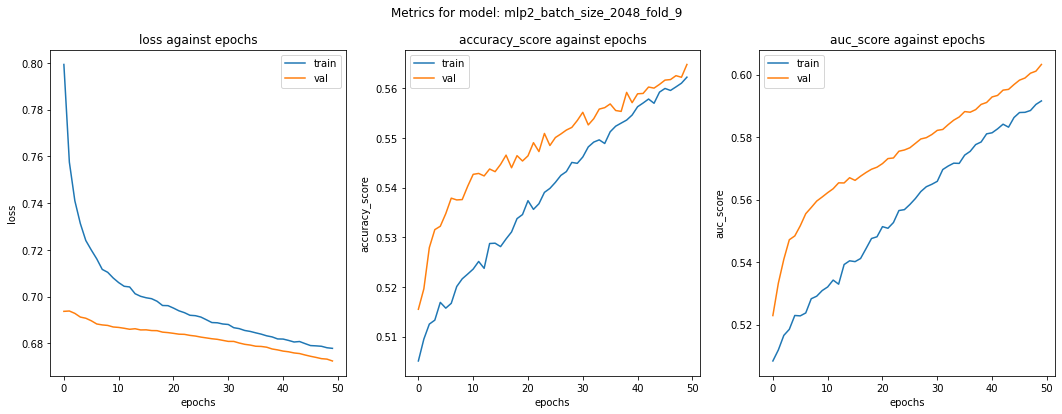

training model fold 10
Epoch 1/50
123/123 [==============================] - 3s 15ms/step - loss: 0.8191 - accuracy: 0.5055 - auc: 0.5078 - val_loss: 0.6934 - val_accuracy: 0.5137 - val_auc: 0.5254
Epoch 2/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7612 - accuracy: 0.5091 - auc: 0.5115 - val_loss: 0.6937 - val_accuracy: 0.5239 - val_auc: 0.5326
Epoch 3/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7451 - accuracy: 0.5092 - auc: 0.5122 - val_loss: 0.6935 - val_accuracy: 0.5262 - val_auc: 0.5359
Epoch 4/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7344 - accuracy: 0.5131 - auc: 0.5156 - val_loss: 0.6925 - val_accuracy: 0.5288 - val_auc: 0.5413
Epoch 5/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7244 - accuracy: 0.5140 - auc: 0.5210 - val_loss: 0.6905 - val_accuracy: 0.5335 - val_auc: 0.5458
Epoch 6/50
123/123 [==============================] - 1s 12ms/step - loss: 0.7203 - accuracy: 0.5162 -

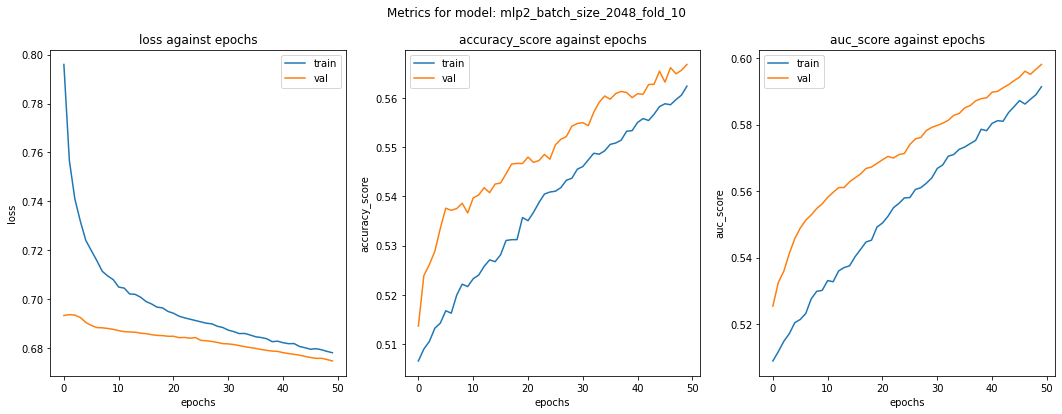

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [675.2128115403528, 0.5670226470195866, 0.5662254567898835, 8623.5, 7215.2, 6465.0, 5629.4]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12B_nndl_cv_mlp2_batch_size"
            model_name = f"mlp2_batch_size_{batch_size}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion

Best performing hyperparameters : batch_size=400
* Utility score: 1140.229306
* Accuracy: 0.601669717

Reducing the batch size improves utility scores, at the expense of longer training times. At batch size of 256, we have not encountered erratic training patterns, therefore we will stick with batch size = 512 for training, but change to 256 for testing

Consistent with 11B but performs better 

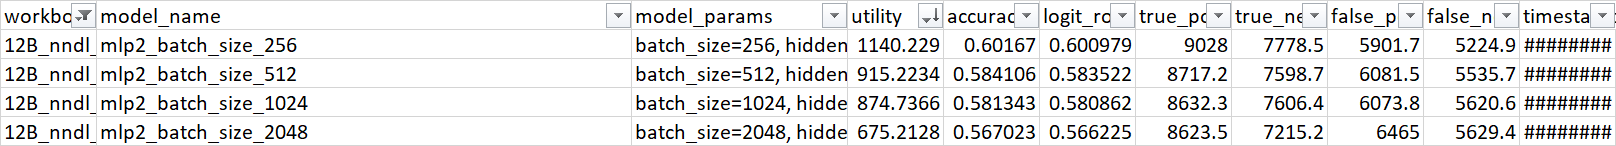